# Create link to data

API User Guide: https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html

In [156]:
import urllib
import datetime

api_key = "2ecc33df-ae91-4de1-a519-c55d4fcbf74c"

base_url = "https://transparency.entsoe.eu/api"


now = datetime.datetime.utcnow()

start_time = now.replace(hour=0, minute=0) - datetime.timedelta(days=7)
end_time = start_time + datetime.timedelta(days=7)

time_format = "%Y%m%d%H%M"

print(start_time.strftime(time_format))
print(end_time.strftime(time_format))



# Example query
#query_url = f"{base_url}?securityToken={api_key}&documentType=A44&in_Domain=10YCZ-CEPS-----N&out_Domain=10YCZ-CEPS-----N&periodStart=201512312300&periodEnd=201612312300"




query_parameters_installed = {"securityToken": api_key,
                    "documentType": "A68",
                    "processType": "A33",
                    "in_Domain": "10Y1001A1001A39I",
                    "periodStart": start_time.strftime(time_format),
                    "periodEnd": end_time.strftime(time_format)}


query_parameters_price = {"securityToken": api_key,
                          "documentType": "A44",
                          "in_Domain": "10Y1001A1001A39I",
                          "out_Domain": "10Y1001A1001A39I",
                          "periodStart": start_time.strftime(time_format),
                          "periodEnd": end_time.strftime(time_format)}

query_parameters_forecast = {"securityToken": api_key,
                            "documentType": "A69",
                            "processType": "A01",
                            "psrType": "B16",
                            "in_Domain": "10Y1001A1001A39I",
                            "periodStart": start_time.strftime(time_format),
                            "periodEnd": end_time.strftime(time_format)}




query_url = f"{base_url}?{urllib.parse.urlencode(query_parameters_forecast)}"


print(query_url)







202011160000
202011230000
https://transparency.entsoe.eu/api?securityToken=2ecc33df-ae91-4de1-a519-c55d4fcbf74c&documentType=A69&processType=A01&psrType=B16&in_Domain=10Y1001A1001A39I&periodStart=202011160000&periodEnd=202011230000


# Get Raw data from Query result

In [157]:
import requests
response = requests.get(query_url)

print(response) # 200 is good

<Response [200]>


# Parse data from XML

In [158]:
!pip install aniso8601

In [159]:
from lxml import etree
import aniso8601

def get_text(parent_element, path, default=None):
    """Returns xml text of first element found in 'parent_element' at defined path.
       Returns empty sting if no element was found."""

    element = parent_element.find(path)

    if element is not None:
        text = element.text
    else:
        text = default

    return text

parsed_data = etree.fromstring(response.content).getroottree()
periods = parsed_data.findall(".//{*}Period")

# Get Meta
root = parsed_data.getroot()
meta = {"root": root.tag.split("}")[1],
        "root_namespace": root.tag.split("}")[0]}

for child in root.getchildren():

  if len(child.getchildren()) == 0:
    meta[child.tag.split("}")[1]] = child.text



# Get Data
result_list = []

for period in periods:

  # Meta

  for child in period.getparent():

    if len(child.getchildren()) == 0:
      meta[child.tag.split("}")[1]] = child.text

  resolution = aniso8601.parse_duration(period.find('.//{*}resolution').text)
  start_time = aniso8601.parse_datetime(period.find('.//{*}start').text)
  end_time   = aniso8601.parse_datetime(period.find('.//{*}end').text)

  points = period.findall("{*}Point")

  for point in points:
    position = int(point.find('{*}position').text)

    value = get_text(point, '{*}price.amount')

    if value == None:
      value = get_text(point, '{*}quantity')
    
    
    start = start_time + resolution * (position - 1)
    end  = start_time + resolution * position

    result_list.append({"utc_start":start, "utc_end":end, "data":float(value)})




In [160]:
meta

{'businessType': 'A94',
 'createdDateTime': '2020-11-23T23:31:51Z',
 'curveType': 'A01',
 'inBiddingZone_Domain.mRID': '10Y1001A1001A39I',
 'mRID': '8',
 'objectAggregation': 'A08',
 'process.processType': 'A01',
 'quantity_Measure_Unit.name': 'MAW',
 'receiver_MarketParticipant.mRID': '10X1001A1001A450',
 'receiver_MarketParticipant.marketRole.type': 'A33',
 'revisionNumber': '1',
 'root': 'GL_MarketDocument',
 'root_namespace': '{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0',
 'sender_MarketParticipant.mRID': '10X1001A1001A450',
 'sender_MarketParticipant.marketRole.type': 'A32',
 'type': 'A69'}

In [161]:
import pandas

dataframe = pandas.DataFrame(result_list).set_index("utc_start")
#dataframe.index = pandas.to_datetime(dataframe.index)

#dataframe

# Visualize data

('root', 'GL_MarketDocument')
('root_namespace', '{urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0')
('mRID', '8')
('revisionNumber', '1')
('type', 'A69')
('process.processType', 'A01')
('sender_MarketParticipant.mRID', '10X1001A1001A450')
('sender_MarketParticipant.marketRole.type', 'A32')
('receiver_MarketParticipant.mRID', '10X1001A1001A450')
('receiver_MarketParticipant.marketRole.type', 'A33')
('createdDateTime', '2020-11-23T23:31:51Z')
('businessType', 'A94')
('objectAggregation', 'A08')
('inBiddingZone_Domain.mRID', '10Y1001A1001A39I')
('quantity_Measure_Unit.name', 'MAW')
('curveType', 'A01')


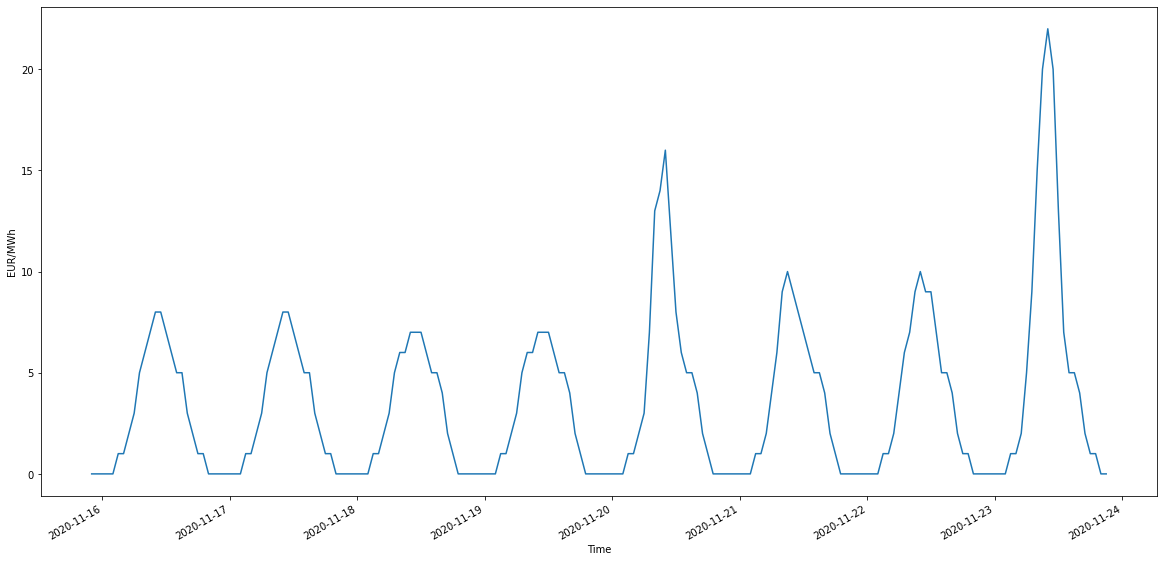

In [162]:
for item in meta.items():
  print(item)
dataframe["data"].plot(figsize=(20, 10), ylabel="EUR/MWh", xlabel="Time")

In [163]:
#dataframe.to_csv("results.csv")